In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import keras
from natsort import natsorted

## Get Data

In [2]:
def get_images(images_path):
    # speichert Bilder als numpy array

    array_images = []
    train_or_test_folder = os.listdir(images_path)

    for folder in natsorted(train_or_test_folder):
        single_folder = os.path.join(images_path, folder)

        for file in os.listdir(single_folder):
            filepath = os.path.join(single_folder, file)

            if filepath.lower().endswith(('.jpeg', '.jpg')):
                image = cv2.resize(cv2.imread(filepath), (64, 64))  # resize Größe bestimmt durch vortainiertes Netz
                array_images.append(image)

    images = np.array(array_images)
    
    return images

In [3]:
def get_label(images_path):
    # speichert Lables als numpy array

    array_label = []
    for folder in natsorted(os.listdir(images_path)):
        label = int(folder)

        for file in os.listdir(os.path.join(images_path, folder)):
            array_label.append(label)
    labels = np.array(array_label)
        
    return labels

In [5]:
images = get_images("../../02_data_crop/train") # train images
labels = get_label("../../02_data_crop/train")  # train labels

X_eval = get_images("../../02_data_crop/test")  # Evaluierungs Bilder
y_eval = get_label("../../02_data_crop/test")   # Evaluierungs Labels

In [6]:
uniq_labels = natsorted(os.listdir("../../02_data_crop/train"))
print("Anzahl eindeutiger Klassen: {}".format(len(uniq_labels)))

Anzahl eindeutiger Klassen: 26


## Preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Trainingsbilder, Testbilder, Trainingslabels, Testlabels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)
# von jeder Klasse Daten

n = len(uniq_labels)   # Anzahl eindeutiger Klassen
train_n = len(X_train) # Anzahl Trainingsdaten
test_n = len(X_test)   # Anzahl Testdaten
eval_n = len(X_eval)

tab = [['Klassen:',n],
       ['Trainingsbilder', train_n],['Testbilder', test_n],['Evaluierungsbilder', eval_n]]

print(tabulate(tab, headers=["Anzahl", "Wert"]))

Anzahl                Wert
------------------  ------
Klassen:                26
Trainingsbilder       8294
Testbilder            2074
Evaluierungsbilder    1448


In [9]:
# one hot encoding der Labels
# Binarisierung, entsprechende Klasse mit 1 gekennzeichnet
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [10]:
print("One hot encoded: {}".format(y_train[0]))
print("Anzahl Klassen: {}".format(len(y_train[0])))
# Dummy Klasse, wenn kein Wert passt

One hot encoded: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Anzahl Klassen: 27


In [11]:
# Normalisierung der Bilder, damit Werte nur noch zwischen 0 und 1
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

## Model 2: Resnet

In [33]:
#Initialising resnet
classifier_resnet = ResNet50(input_shape= (64,64,3),include_top=False,weights='imagenet')

In [34]:
#don't train existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

In [36]:
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=27, activation='softmax')(classifier2)

model_resnet = Model(inputs = classifier_resnet.input , outputs = classifier2)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model_resnet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,808,923 (90.82 MB)

 Trainable params: 221,211 (864.11 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
#fit the model
history_resnet = model_resnet.fit(X_train, y_train, epochs=6, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 80s 465ms/step - accuracy: 0.0866 - loss: 3.2946 - val_accuracy: 0.2642 - val_loss: 2.6577
Epoch 2/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - accuracy: 0.1881 - loss: 2.7019 - val_accuracy: 0.2903 - val_loss: 2.4823
Epoch 3/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 422ms/step - accuracy: 0.2305 - loss: 2.5438 - val_accuracy: 0.3071 - val_loss: 2.3570
Epoch 4/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 422ms/step - accuracy: 0.2554 - loss: 2.4473 - val_accuracy: 0.3549 - val_loss: 2.2821
Epoch 5/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 419ms/step - accuracy: 0.2783 - loss: 2.3880 - val_accuracy: 0.3626 - val_loss: 2.2262
Epoch 6/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 422ms/step - accuracy: 0.2878 - loss: 2.3501 - val_accuracy: 0.4103 - val_loss: 2.1670


In [ ]:
# Saving the model of resnet
model_resnet.save('./Model/model_resnet.h5')

In [39]:
score = model_resnet.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model_resnet.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 41.032 %
Accuracy for evaluation images: 42.68 %


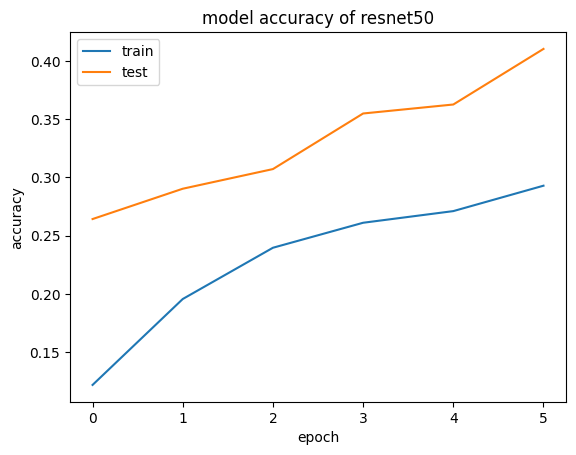

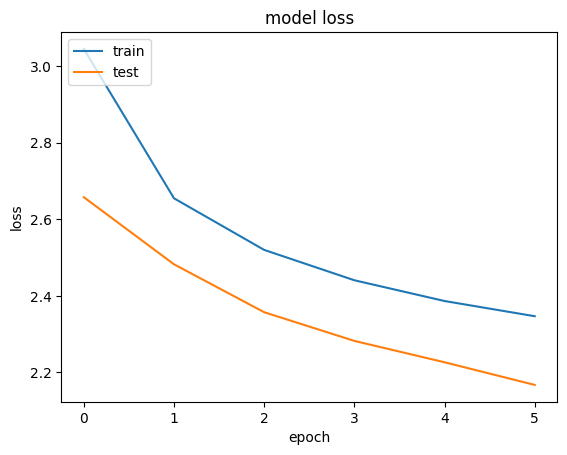

In [40]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('model accuracy of resnet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

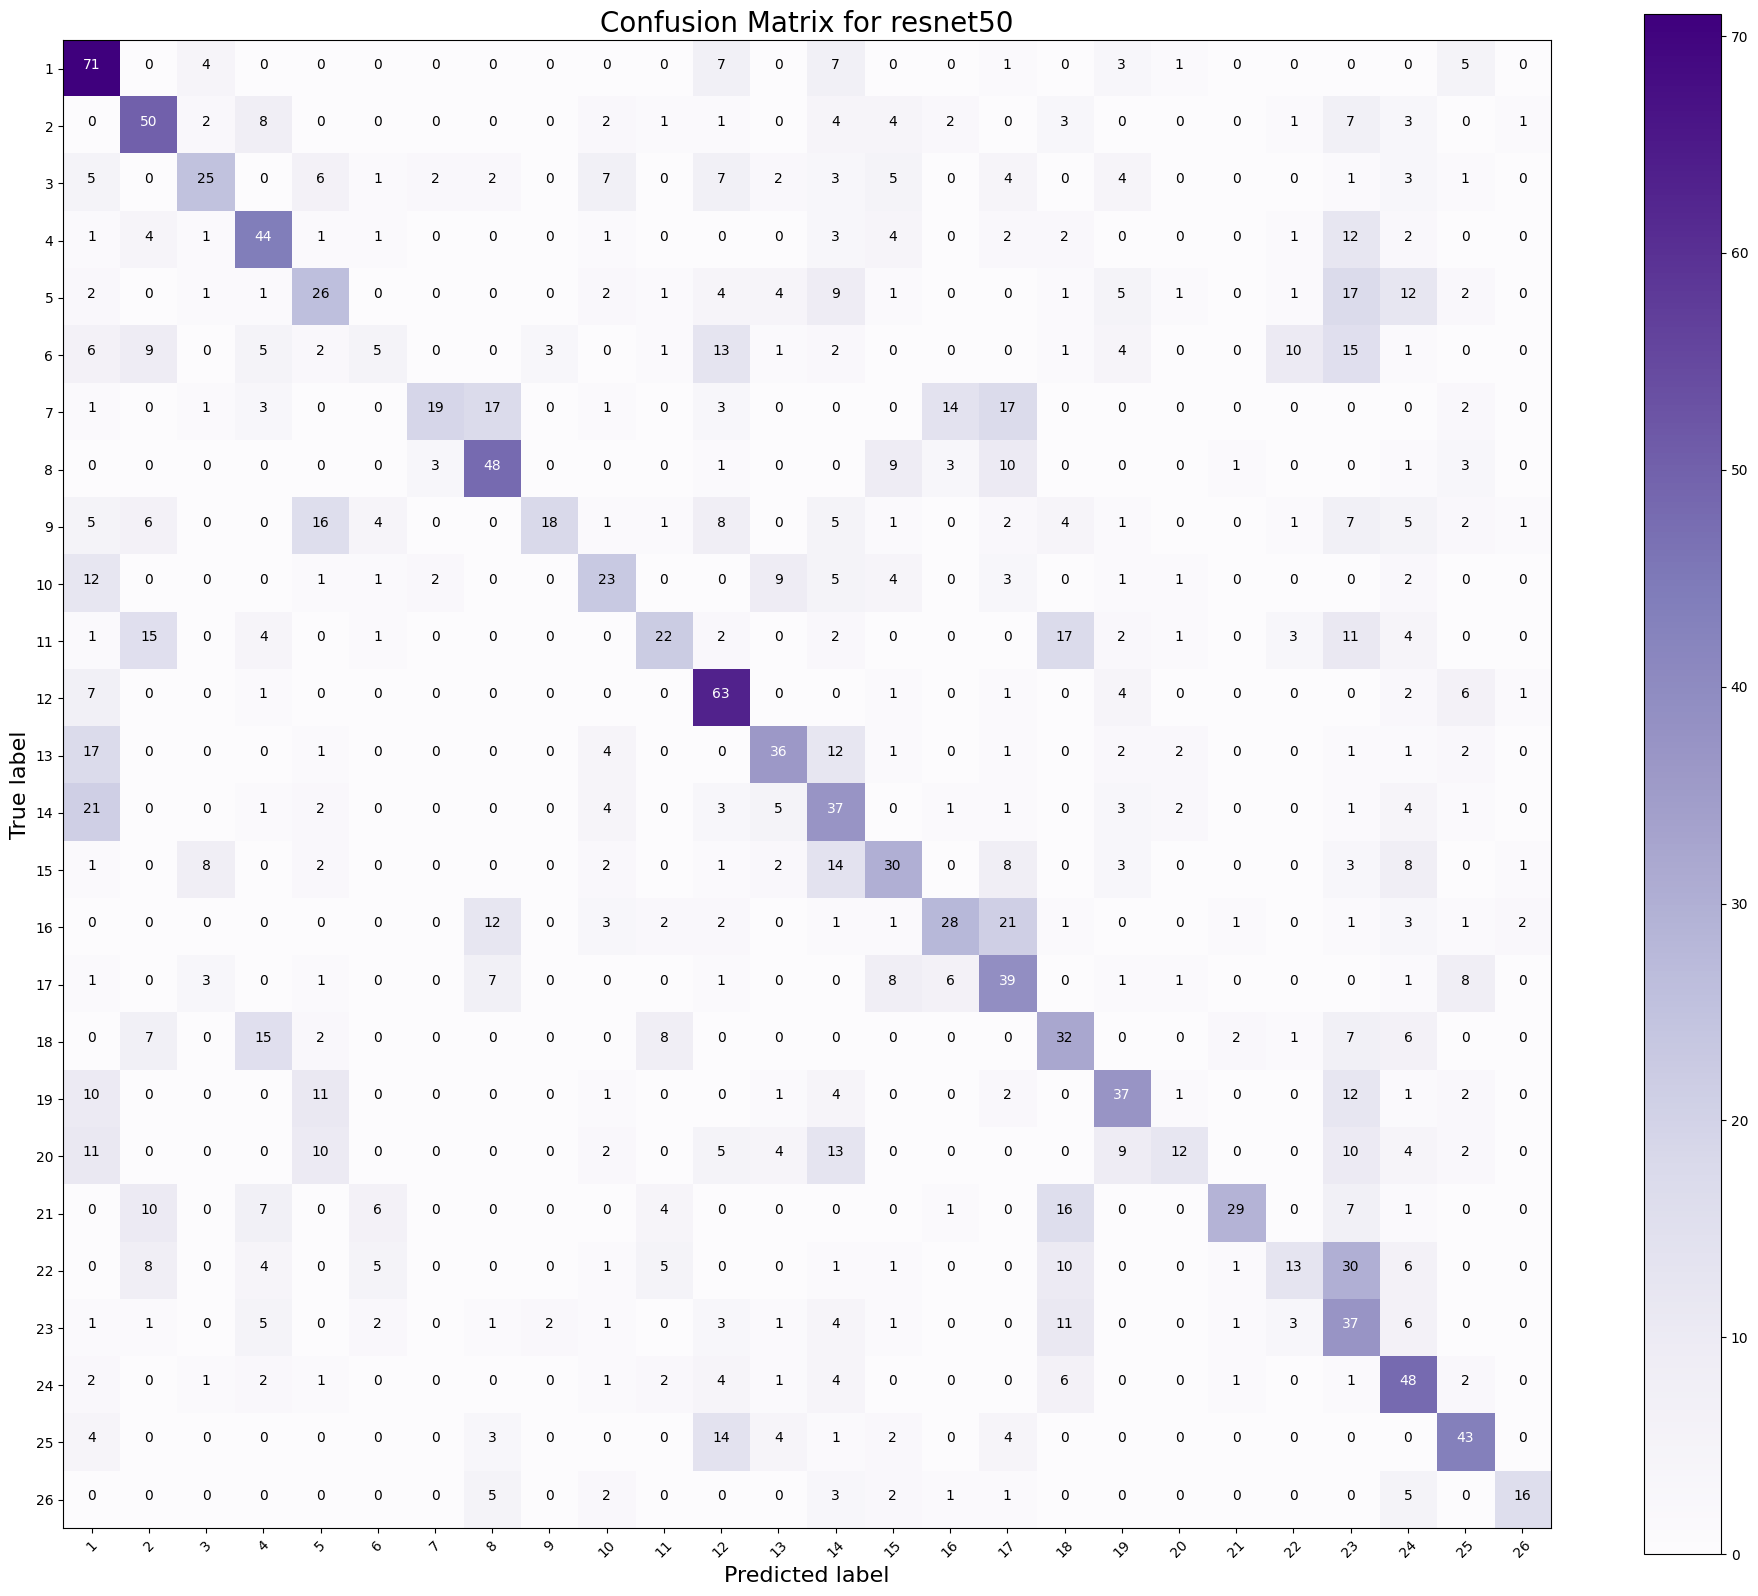

In [41]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix for resnet50")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model_resnet.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

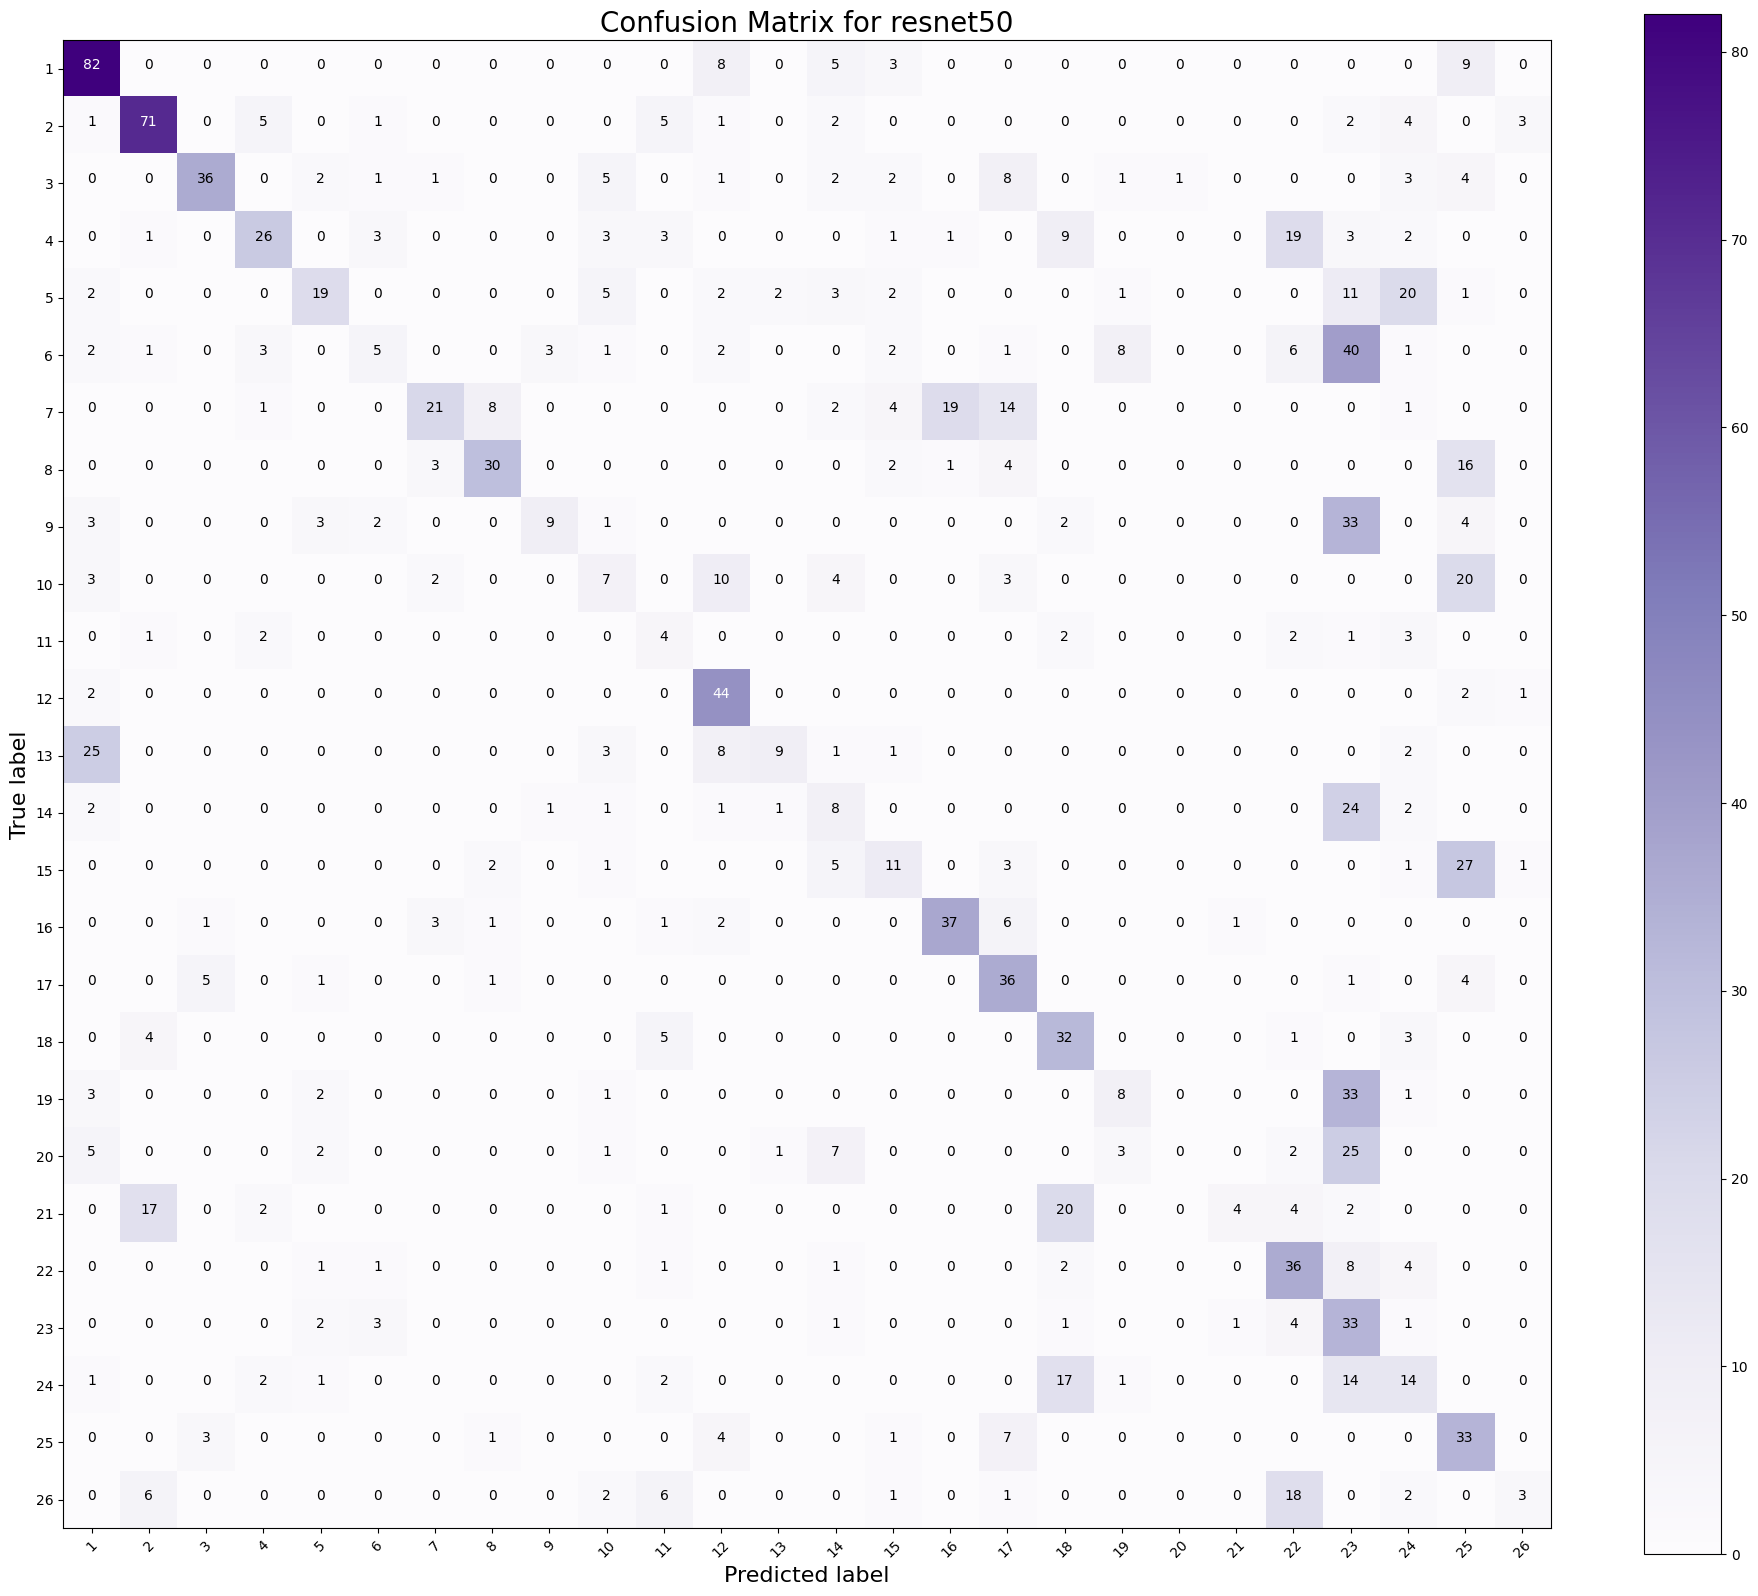

In [42]:
y_eval_pred = model_resnet.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
M


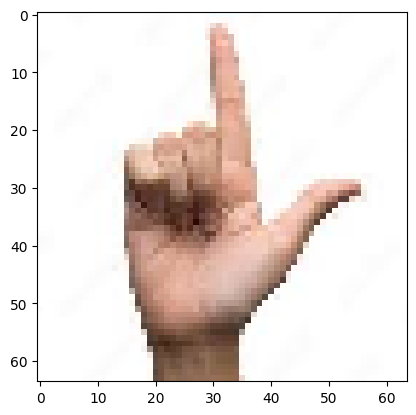

In [43]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('./l.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model_resnet.predict(test_image)

if result[0][0] == 1:
    prediction = 'A'
elif result[0][1] == 1:
    prediction = 'B'
elif result[0][2] == 1:
    prediction = 'C'
elif result[0][3] == 1:
    prediction = 'D'
elif result[0][4] == 1:
    prediction = 'E'
elif result[0][5] == 1:
    prediction = 'F'
elif result[0][6] == 1:
    prediction = 'G'
elif result[0][7] == 1:
    prediction = 'H'
elif result[0][8] == 1:
    prediction = 'I'
elif result[0][9] == 1:
    prediction = 'J'
elif result[0][10] == 1:
    prediction = 'K'
elif result[0][11] == 1:
    prediction = 'L'
elif result[0][12] == 1:
    prediction = 'M'
elif result[0][13] == 1:
    prediction = 'N'
elif result[0][14] == 1:
    prediction = 'O'
elif result[0][15] == 1:
    prediction = 'P'
elif result[0][16] == 1:
    prediction = 'Q'
elif result[0][17] == 1:
    prediction = 'R'
elif result[0][18] == 1:
    prediction = 'S'
elif result[0][19] == 1:
    prediction = 'T'
elif result[0][20] == 1:
    prediction = 'U'
elif result[0][21] == 1:
    prediction = 'V'
elif result[0][22] == 1:
    prediction = 'W'
elif result[0][23] == 1:
    prediction = 'X'
elif result[0][24] == 1:
    prediction = 'Y'
elif result[0][25] == 1:
    prediction = 'Z'

    
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Vorhergesagte Klasse:  I


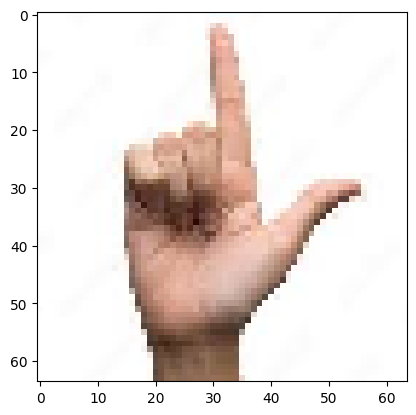

In [44]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('l.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model_resnet.predict(test_image)

# Finde den Index des höchsten Werts in result
predicted_class_index = np.argmax(result)

# Lade die Klassenbezeichnungen
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] # Füge hier deine Klassenbezeichnungen hinzu

# Zeige die Vorhersage an
print("Vorhergesagte Klasse: ", class_labels[predicted_class_index])